## Tracking how peak intensity varies over time due to amortisation

Deterministic LGD (= 1)

In [1]:
import numpy as np
import scipy
from scipy.stats import ncx2
from scipy.special import hyp1f1
from scipy.optimize import brentq
from math import exp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kurtosis

DECIMALS = 6

np.set_printoptions(precision=DECIMALS, suppress=True)
pd.options.display.float_format = lambda x: f"{x:.{DECIMALS}f}"
pd.set_option("display.precision", DECIMALS)

In [2]:
def lambda_max_generator(epsilon, y, theta, sigma, kappa, max_attempts=5, tol=1e-8):
    """
    
    Compute H^*_epsilon such that P_y(sigma_H < tau) = G_y(H; H) <= epsilon.
    This function implements Equation (11) using the closed-form in Equation (19).

    """

    def G_y(H):

        a = H / kappa  # Now using H as the Laplace exponent (since tau ~ Exp(H))
        b = 2 * kappa * theta / sigma**2
        z_y = 2 * kappa * y / sigma**2
        z_H = 2 * kappa * H / sigma**2

        num = hyp1f1(a, b, z_y)
        denom = hyp1f1(a, b, z_H)
        
        return num / denom  # This is G_y(H; H) = E[e^{-H * sigma_H}]

    def root_function(H):
        return G_y(H) - epsilon

    # Bracketing interval
    H_min = y + 1e-8
    H_max = y + 10.0

    # Expand H_max until G_y(H_max) < epsilon
    for _ in range(max_attempts):
        try:
          H_star = scipy.optimize.toms748(root_function, H_min, H_max, xtol=tol)
          
          if root_function(H_star)<=0:
            
            return H_star
          
          else:
          
            while root_function(H_star)>0:
              H_star = H_star + 1e-2
          
            return H_star
          
        except Exception:
            pass
        
        H_max += 5.0

    # Fallback: scan manually to find conservative H
    print("[Warning] brentq failed to converge. Using fallback grid search.")
    H_vals = np.linspace(H_min, H_max + 50, 1000)
    for H in H_vals:
        if G_y(H) <= epsilon:
            return H

    raise RuntimeError("Unable to find H^*_epsilon. Try expanding search space.")


In [3]:
def cir_transition_sample_per_sector(y_vec, tau, kappa_vec, theta_vec, sigma_vec, rng):
    """
    y_vec, kappa_vec, theta_vec, sigma_vec are arrays of length J (sectors).
    Returns xi_vec: sampled Y_{t+tau} per sector (length J).
    """
    if tau <= 0:
        return y_vec.copy()
    
    one_minus = -np.expm1(-kappa_vec * tau)  # = 1 - exp(-kappa*tau)
    # avoid zeros
    one_minus = np.where(one_minus <= 0, 1e-16, one_minus)
    
    c = (sigma_vec * sigma_vec * one_minus) / (4.0 * kappa_vec)
    d = 4.0 * kappa_vec * theta_vec / (sigma_vec * sigma_vec)
    
    # noncentrality parameters
    nc = (4.0 * kappa_vec * np.exp(-kappa_vec * tau) * y_vec) / (sigma_vec * sigma_vec * one_minus)
    
    # guard
    d = np.maximum(d, 1e-12)
    nc = np.maximum(nc, 0.0)
    
    # sample per sector (simple looping works fine since J would be typically small)
    xi = np.empty_like(y_vec, dtype=float)

    for j in range(len(y_vec)):
    
        # If df or nc are extreme, ncx2.rvs might throw an error
        try:
            Z = ncx2.rvs(df=d[j], nc=nc[j], random_state=rng)
    
        except Exception:
            Z = ncx2.rvs(df=max(d[j],1e-6), nc=0.0, random_state=rng) + nc[j]
    
        xi[j] = c[j] * Z
    
    xi = np.maximum(xi, 0.0)
    
    return xi


In [4]:
from scipy.interpolate import interp1d

def loss_distribution_plot(Payoff_T,index):
  # Get histogram data (without plotting)
  counts, bin_edges = np.histogram(Payoff_T, bins=10, density=True)

  # Get bin centers
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

  # Interpolation function
  f_interp = interp1d(bin_centers, counts, kind='cubic', fill_value="extrapolate")

  # New x-values for smooth curve
  x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
  y_smooth = f_interp(x_smooth)

  # Plot histogram and interpolated curve
  plt.hist(Payoff_T, bins=100, density=True, label='Histogram_'+str(index),alpha = 0.4)
  plt.plot(x_smooth, y_smooth, label='Loss Distribution Case_'+str(index))
  plt.xlabel('Loss')
  plt.ylabel('Density')
  # plt.legend()


In [5]:
def expected_shortfall(losses, alpha=0.95):
    var_alpha = np.quantile(losses, alpha)
    tail_losses = losses[losses >= var_alpha]
    return float(np.round(tail_losses.mean(), DECIMALS))

def compute_loss_metrics(losses, alpha=0.95):
    var_alpha = np.quantile(losses, alpha)
    es = expected_shortfall(losses, alpha)

    # E_max_intensity = np.mean(Y_max_vals)

    metrics = {
        # "Mean Max Intensity": E_max_intensity,
        "Mean": np.mean(losses),
        "Std": np.std(losses),
        "VaR": var_alpha,
        "ES": es,
        "Excess ES": es - var_alpha,
        "ExcessKurtosis": kurtosis(losses)
    }
    return {key: float(np.round(value, DECIMALS)) for key, value in metrics.items()}

In [ ]:
def peak_intensity_metrics(Y_max_vals): 
    return { "Mean Peak Intensity": np.mean(Y_max_vals), 
            "Std Peak Intensity": np.std(Y_max_vals), 
            "Q90 Peak Intensity": np.quantile(Y_max_vals, 0.90), 
            "Q95 Peak Intensity": np.quantile(Y_max_vals, 0.95), 
            "Q99 Peak Intensity": np.quantile(Y_max_vals, 0.99)
}

def plot_mean_peak_intensity(Y_max, ci=0.95):
    means = []
    lower = []
    upper = []

    alpha = (1 - ci) / 2

    for Y_vals in Y_max:
        means.append(np.mean(Y_vals))
        lower.append(np.quantile(Y_vals, alpha))
        upper.append(np.quantile(Y_vals, 1 - alpha))

    means = np.array(means)
    lower = np.array(lower)
    upper = np.array(upper)

    plt.figure(figsize=(7, 4))
    plt.bar(range(len(means)), means, yerr=[means - lower, upper - means], capsize=6)

    plt.ylabel("Peak Systemic Intensity $Y_{max}$")
    plt.title("Mean Peak Systemic Intensity with Confidence Intervals")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [7]:
loan_types = ["bullet", "linear", "french", "negative"]

def bullet_exposure(contract, T, t):
    P = float(contract["P"])
    return P if t < T else 0.0


def linear_exposure(contract, T, t):
    P = float(contract["P"])
    periods_per_year = float(contract["N"])
    if periods_per_year <= 0 or T <= 0:
        return 0.0

    period = 1.0 / periods_per_year  # years per period
    total_periods = int(np.ceil(T * periods_per_year))
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, total_periods))
    principal_paid = (payments_made / total_periods) * P
    return max(P - principal_paid, 0.0)


def french_exposure(contract, T, t):
    P = float(contract["P"])
    periods_per_year = float(contract["N"])
    r_annual = float(contract["r"])
    if periods_per_year <= 0 or T <= 0:
        return 0.0

    period = 1.0 / periods_per_year  # years per period
    total_periods = int(np.ceil(T * periods_per_year))
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, total_periods))
    periods_remaining = total_periods - payments_made
    if periods_remaining <= 0:
        return 0.0

    r_period = r_annual / periods_per_year  # annual to per-period rate

    if r_period == 0.0:
        payment = P / total_periods
        return payment * periods_remaining

    annuity_payment = P * r_period / (1.0 - (1.0 + r_period) ** (-total_periods))
    pv_remaining = annuity_payment * (1.0 - (1.0 + r_period) ** (-periods_remaining)) / r_period
    return pv_remaining


def negative_amortization_exposure(contract, T, t):
    P = float(contract["P"])
    periods_per_year = float(contract["N"])
    r_annual = float(contract.get("r", 0.0))
    if periods_per_year <= 0 or T <= 0:
        return max(P, 0.0)

    period = 1.0 / periods_per_year  # years per period
    total_periods = int(np.ceil(T * periods_per_year))
    periods_elapsed = int(np.floor(t / period))
    periods_elapsed = int(np.clip(periods_elapsed, 0, total_periods))

    r_period = r_annual / periods_per_year  # annual to per-period rate

    exposure = P * ((1.0 + r_period) ** periods_elapsed)

    return exposure if t < T else 0.0


def exposure_at_time(contract, T, t):
    loan_type = str(contract["type"]).lower()
    dispatch = {
        "bullet": bullet_exposure,
        "linear": linear_exposure,
        "french": french_exposure,
        "negative": negative_amortization_exposure,
    }
    if loan_type not in dispatch:
        raise ValueError(f"Unknown loan type: {loan_type}")
    return dispatch[loan_type](contract, T, t)


In [8]:
def generate_portfolio_weights(N, J, composition_type, concentration_params=None, rng=None):
    """
    Build portfolio weights under three stylised configurations plus a random fallback.

    - concentrated: one dominant sector for every obligor (eg for J=3 [0.7, 0.2, 0.1])
    - balanced: evenly distributed across sectors (eg for J=3  [1/3, 1/3, 1/3])
    - mixed: partial concentration with residual diversified weights (eg for J=3  [0.5, 0.3, 0.2])
    - random: symmetric Dirichlet for variation.
    """
    if rng is None:
        rng = np.random.default_rng()

    if concentration_params is None:
        concentration_params = {}

    noise_level = concentration_params.get("noise_level", 0.0)
    alpha_random = concentration_params.get("alpha", 1.0)

    if composition_type == "concentrated":
        pattern = _pattern_concentrated(J)
        W = _apply_noise_and_normalize(pattern, N, noise_level, rng)
    elif composition_type == "balanced":
        pattern = _pattern_balanced(J)
        W = _apply_noise_and_normalize(pattern, N, noise_level, rng)
    elif composition_type == "mixed":
        pattern = _pattern_mixed(J)
        W = _apply_noise_and_normalize(pattern, N, noise_level, rng)
    elif composition_type == "random":
        W = _generate_random_weights(N, J, {"alpha": alpha_random}, rng)
    else:
        raise ValueError(f"Unknown composition_type: {composition_type}")

    return W


def _pattern_concentrated(J, dominant=0.7):
    if J <= 0:
        return np.array([])
    if J == 1:
        return np.array([1.0])
    residual = max(1.0 - dominant, 0.0)
    tail = residual / (J - 1)
    vec = np.full(J, tail)
    vec[0] = dominant
    return vec


def _pattern_balanced(J):
    if J <= 0:
        return np.array([])
    return np.full(J, 1.0 / J)


def _pattern_mixed(J, primary=0.5, secondary=0.3):
    if J <= 0:
        return np.array([])
    vec = np.zeros(J)
    vec[0] = min(primary, 1.0)
    if J >= 2:
        vec[1] = min(secondary, max(1.0 - vec[0], 0.0))
    residual = max(1.0 - vec.sum(), 0.0)
    if J > 2:
        vec[2:] = residual / (J - 2)
    elif J == 1:
        vec[0] = 1.0
    else:
        vec[1] += residual
    return vec


def _apply_noise_and_normalize(pattern, N, noise_level, rng):
    base = np.tile(pattern, (N, 1))
    if noise_level > 0:
        noise = rng.normal(0.0, noise_level, size=base.shape)
        base = base + noise
    base = np.maximum(base, 1e-6)
    base = base / base.sum(axis=1, keepdims=True)
    return base


def _generate_random_weights(N, J, params, rng):
    alpha = params.get("alpha", 1.0)
    W = np.zeros((N, J))
    for i in range(N):
        W[i] = rng.dirichlet(np.full(J, alpha))
    return W

In [9]:
def simulate_sector_cir_model(kappa, theta, sigma, T, delta, W, eps, lambda_benchmark,
                              Nfirms, idiosyncratic_factor, loan_contracts, rng=None):

    import warnings

    if rng is None:
        rng = np.random.default_rng()

    # ensure shapes
    J = len(theta)
    assert W.shape == (Nfirms, J)
    idiosyncratic_factor = np.asarray(idiosyncratic_factor).reshape(Nfirms,)
    lambda_benchmark = np.asarray(lambda_benchmark).reshape(J,)

    delta = np.asarray(delta)
    if delta.ndim == 1:
        delta = np.tile(delta.reshape(1, J), (Nfirms, 1))
    assert delta.shape == (Nfirms, J)

    # init
    t = 0.0
    Y_t = theta.copy().astype(float)   # sectoral intensities (J-vector), initialised at theta
    events = []
    owed = []
    marks = []
    defaulter_idio_factor = []
    sector_contributions = []
    alive = np.arange(Nfirms, dtype=int)

    # precompute some arrays for speed
    kappa = np.asarray(kappa, dtype=float)
    sigma = np.asarray(sigma, dtype=float)
    theta = np.asarray(theta, dtype=float)

    max_Y = np.sum(Y_t)

    # event loop
    while (t < T) and (alive.size > 0):

        lambda_max = np.maximum(Y_t, lambda_benchmark)  # J-vector
        # Hepsilon = sum_i [ X_i + w_i · lambda_max ] over alive firms
        
        # We can compute per-firm value and sum
        per_firm_sys = W[alive].dot(lambda_max)   # length alive.size
        per_firm_idio = idiosyncratic_factor[alive]
        Hepsilon = per_firm_sys.sum() + per_firm_idio.sum()

        if Hepsilon <= 0:
            break

        # sample a candidate waiting time
        tau = rng.exponential(1.0 / Hepsilon)
        t_candidate = t + tau
        if t_candidate >= T:
            break

        # sample sectoral Y at t_candidate conditional on no defaults in the waiting time
        Y_proposed = cir_transition_sample_per_sector(Y_t, tau, kappa, theta, sigma, rng)

        # compute proposed per-firm intensities (scalar values) using Y_proposed
        per_firm_sys_prop = W[alive].dot(Y_proposed)
        per_firm_total_prop = per_firm_sys_prop + per_firm_idio
        lambda_proposed_total = per_firm_total_prop.sum()

        # acceptance probability: Xi / Hepsilon where Xi = lambda_proposed_total
        accept_prob = min(lambda_proposed_total / Hepsilon, 1.0)
        if rng.random() < accept_prob:
            # accept a default at t_candidate
            t = t_candidate
            events.append(t)

            # choose which alive firm defaulted
            probs = per_firm_total_prop / lambda_proposed_total
            probs = np.maximum(probs, 0.0)
            probs = probs / probs.sum()
            selected_local_idx = rng.choice(len(alive), p=probs)
            selected_firm = int(alive[selected_local_idx])

            # record idiosyncratic factor
            defaulter_idio_factor.append(float(idiosyncratic_factor[selected_firm]))

            sector_contributions.append(W[selected_firm].copy())

            # mark (loss) from contract exposure
            contract = loan_contracts[selected_firm]
            exposure = exposure_at_time(contract, T, t)
            if exposure < 0:
                warnings.warn("Exposure computed negative; clamping to zero.")
                exposure = max(exposure, 0.0)
            if t >= T and exposure > 0:
                warnings.warn("Exposure positive after maturity; forcing to zero.")
                exposure = 0.0

            owed.append(exposure)
            
            # LGD = rng.uniform(0,1)
            # mark = LGD * exposure
            mark =  exposure
            if mark < 0:
                warnings.warn("Loss mark negative; clamping to zero.")
                mark = max(mark, 0.0)
            marks.append(mark)

            # update Y_t with contagion
            Y_t = Y_proposed + delta[selected_firm] * mark/contract["P"]

            # remove defaulted firm from alive set
            alive = np.delete(alive, selected_local_idx)

        else:
            # reject, ie no default: advance time and set Y_t = Y_proposed
            t = t_candidate
            Y_t = Y_proposed
        
        max_Y = max(max_Y, np.sum(Y_t))

    return (np.array(events), np.array(marks), np.array(owed),
            np.array(defaulter_idio_factor), np.array(sector_contributions), max_Y)

In [10]:
def run_simulation(params, loan_contracts, num_trials, seed=42):

    rng = np.random.default_rng(seed)
    eps = 1e-5
    losses = np.zeros(num_trials)
    Y_max_vals = np.zeros(num_trials)
    for i in range(num_trials):
        events, marks, _, _, _, max_Y = simulate_sector_cir_model(params['kappa'], params['theta'], params['sigma'], 
                          params['T'], params['delta'], params['W'], 1e-5, 
                          params['lambda_benchmark'], 
                          params['Firms'], params['idio_factor'], 
                          loan_contracts,
                          rng)
        losses[i] = np.sum(marks)
        Y_max_vals[i] = max_Y

    return losses, Y_max_vals

## Balanced sectoral config; Lower contagion (0.01)

In [18]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 2.0

NUM_TRIALS = 2500

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "balanced", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


In [19]:
params_df = pd.DataFrame({
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'lambda_benchmark': lambda_benchmark
}, index=[f'Sector_{j}' for j in range(J)])

print("Parameters per Sector:")
print(params_df)

print("\n\nPortfolio Weights (W):")
W_df = pd.DataFrame(W, columns=[f'Sector_{j}' for j in range(J)], index=pd.Index(range(N_firms), name='Firm'))
print(W_df)

Parameters per Sector:
            kappa    theta    sigma  lambda_benchmark
Sector_0 0.694378 0.048318 0.135817          0.259574
Sector_1 1.121571 0.049001 0.152923          0.229543
Sector_2 1.408060 0.014160 0.085078          0.076515


Portfolio Weights (W):
      Sector_0  Sector_1  Sector_2
Firm                              
0     0.333333  0.333333  0.333333
1     0.333333  0.333333  0.333333
2     0.333333  0.333333  0.333333
3     0.333333  0.333333  0.333333
4     0.333333  0.333333  0.333333
...        ...       ...       ...
995   0.333333  0.333333  0.333333
996   0.333333  0.333333  0.333333
997   0.333333  0.333333  0.333333
998   0.333333  0.333333  0.333333
999   0.333333  0.333333  0.333333

[1000 rows x 3 columns]


           Mean      Std         VaR          ES  Excess ES  ExcessKurtosis  \
Bullet 3.770219 0.293028 7900.000000 8037.165354 137.165354        0.400547   

            Q90      Q95      Q99  
Bullet 4.141926 4.246021 4.436588  


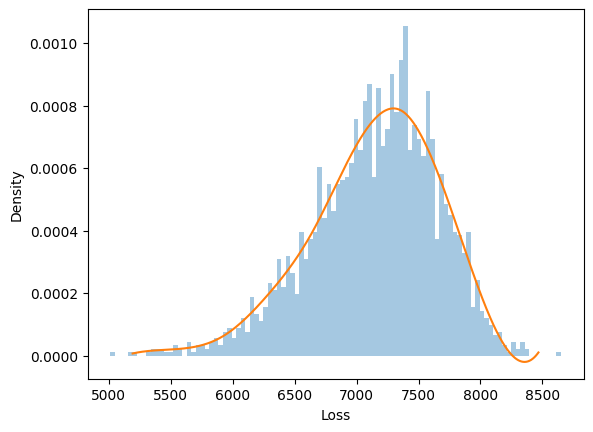

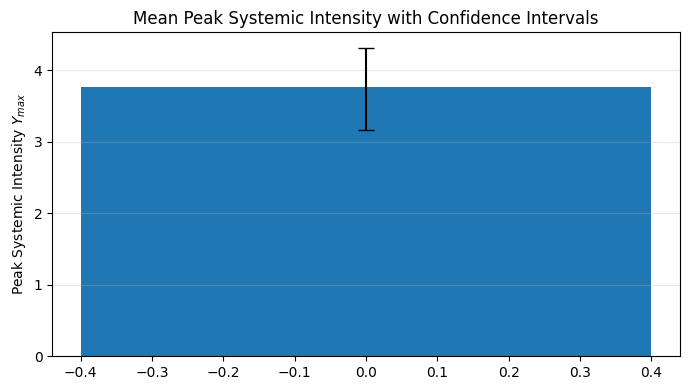

In [20]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b, Y_max_vals_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_loss_metrics(losses_b, alpha=0.95)
int_metrics_b = peak_intensity_metrics(Y_max_vals_b)
metrics_b_df = pd.DataFrame({**metrics_b, **int_metrics_b}, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')
plot_mean_peak_intensity([Y_max_vals_b], ci=0.95)


In [21]:
def plot_Ymax_vs_loss(Y_max_vals, losses):
    plt.figure(figsize=(6, 5))
    plt.scatter(Y_max_vals, losses, alpha=0.4)
    plt.xlabel("Peak Systemic Intensity $Y_{max}$")
    plt.ylabel("Total Portfolio Loss")
    plt.title("Peak Systemic Intensity vs Total Loss")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

0.6987321060467814


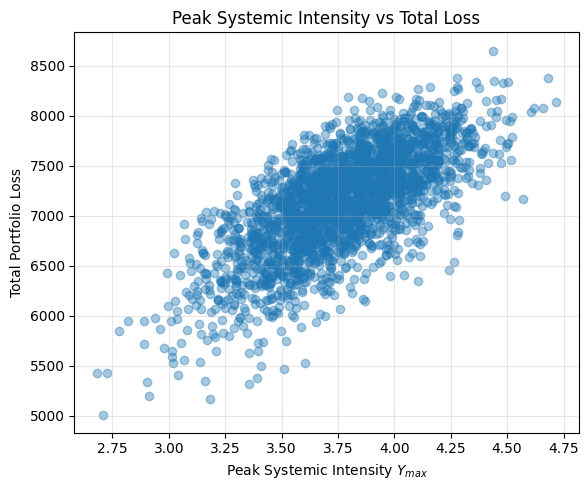

In [22]:
print(np.corrcoef(Y_max_vals_b, losses_b)[0,1])

plot_Ymax_vs_loss(Y_max_vals_b, losses_b)


           Mean      Std         VaR          ES  Excess ES  ExcessKurtosis  \
French 1.157472 0.221922 2699.402751 2849.902719 150.499968        0.050176   

            Q90      Q95      Q99  
French 1.442808 1.531572 1.702788  


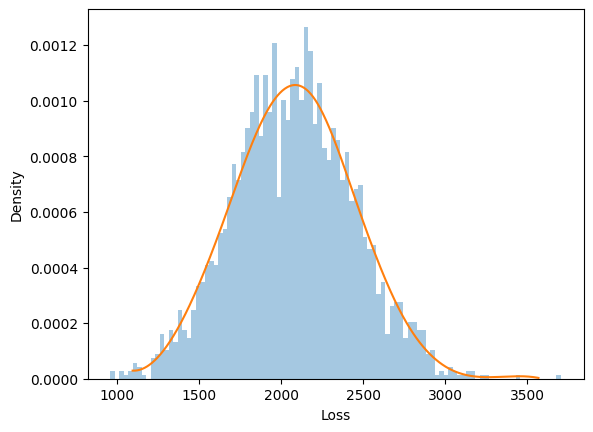

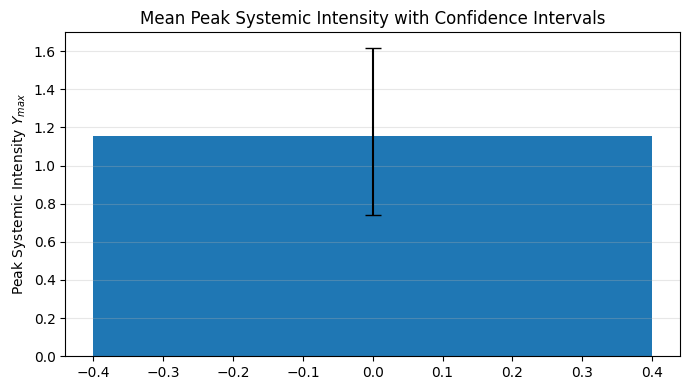

0.9271380869334135


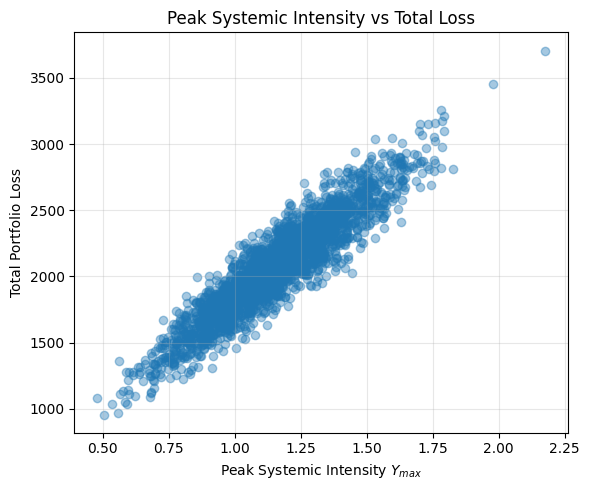

In [23]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f, Y_max_vals_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_loss_metrics(losses_f, alpha=0.95)
int_metrics_f = peak_intensity_metrics(Y_max_vals_f)
metrics_f_df = pd.DataFrame({**metrics_f, **int_metrics_f}, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French Loan')
plot_mean_peak_intensity([Y_max_vals_f], ci=0.95)

print(np.corrcoef(Y_max_vals_f, losses_f)[0,1])
plot_Ymax_vs_loss(Y_max_vals_f, losses_f)


           Mean      Std         VaR          ES  Excess ES  ExcessKurtosis  \
Linear 1.078869 0.217803 2522.562500 2679.413333 156.850833       -0.017264   

            Q90      Q95      Q99  
Linear 1.371568 1.453410 1.631283  


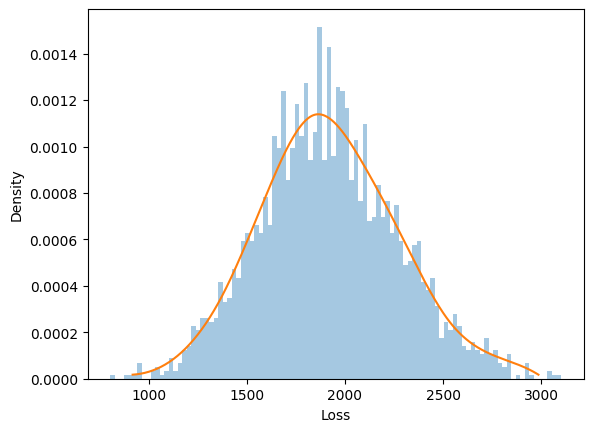

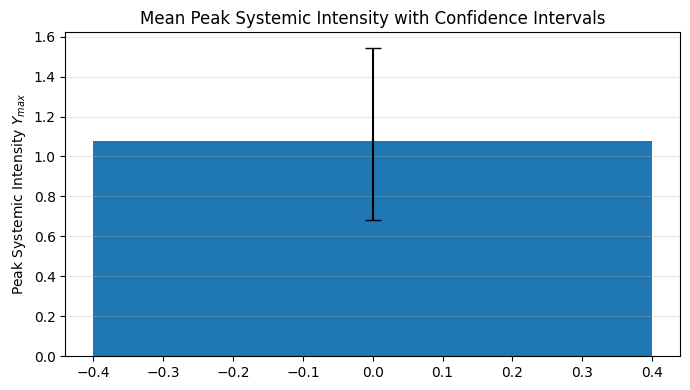

0.9295424588853557


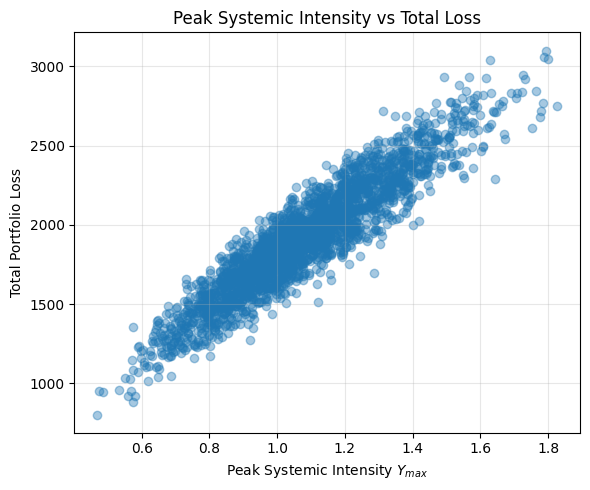

In [24]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l, Y_max_vals_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_loss_metrics(losses_l, alpha=0.95)
int_metrics_l = peak_intensity_metrics(Y_max_vals_l)
metrics_l_df = pd.DataFrame({**metrics_l, **int_metrics_l}, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear Loan')
plot_mean_peak_intensity([Y_max_vals_l], ci=0.95)

print(np.corrcoef(Y_max_vals_l, losses_l)[0,1])
plot_Ymax_vs_loss(Y_max_vals_l, losses_l)


## Concentrated sectoral config; Lower contagion (0.01)

In [25]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 2.0

NUM_TRIALS = 2500

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "concentrated", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}


Feller condition (should be >=1): [3.637663 4.700201 5.508869]


In [26]:
params_df = pd.DataFrame({
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'lambda_benchmark': lambda_benchmark
}, index=[f'Sector_{j}' for j in range(J)])

print("Parameters per Sector:")
print(params_df)

print("\n\nPortfolio Weights (W):")
W_df = pd.DataFrame(W, columns=[f'Sector_{j}' for j in range(J)], index=pd.Index(range(N_firms), name='Firm'))
print(W_df)


Parameters per Sector:
            kappa    theta    sigma  lambda_benchmark
Sector_0 0.694378 0.048318 0.135817          0.259574
Sector_1 1.121571 0.049001 0.152923          0.229543
Sector_2 1.408060 0.014160 0.085078          0.076515


Portfolio Weights (W):
      Sector_0  Sector_1  Sector_2
Firm                              
0     0.700000  0.150000  0.150000
1     0.700000  0.150000  0.150000
2     0.700000  0.150000  0.150000
3     0.700000  0.150000  0.150000
4     0.700000  0.150000  0.150000
...        ...       ...       ...
995   0.700000  0.150000  0.150000
996   0.700000  0.150000  0.150000
997   0.700000  0.150000  0.150000
998   0.700000  0.150000  0.150000
999   0.700000  0.150000  0.150000

[1000 rows x 3 columns]


           Mean      Std         VaR          ES  Excess ES  ExcessKurtosis  \
Bullet 5.948172 0.263535 9890.000000 9905.767196  15.767196        1.794397   

            Q90      Q95      Q99  
Bullet 6.292149 6.385752 6.541825  


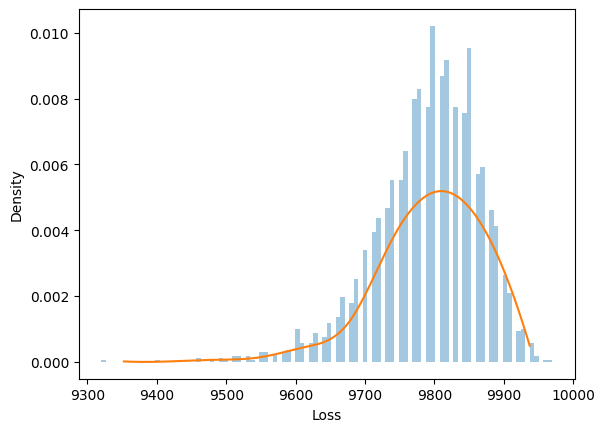

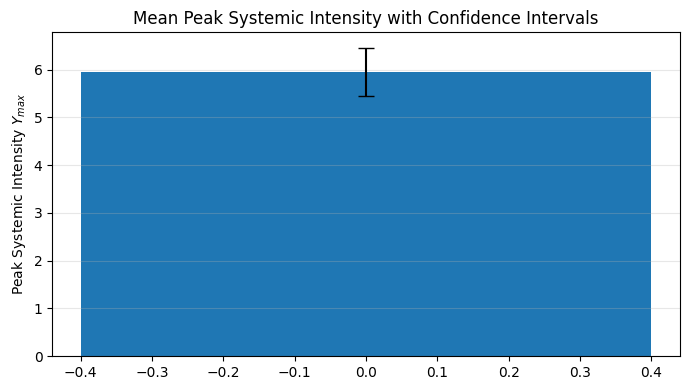

0.530823053663666


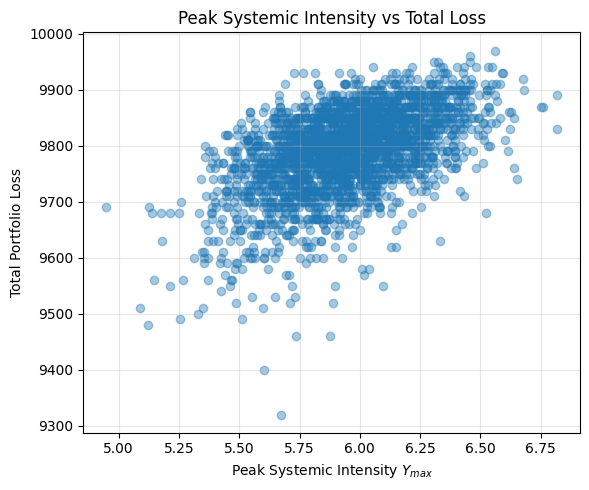

In [27]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b, Y_max_vals_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_loss_metrics(losses_b, alpha=0.95)
int_metrics_b = peak_intensity_metrics(Y_max_vals_b)
metrics_b_df = pd.DataFrame({**metrics_b, **int_metrics_b}, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')
plot_mean_peak_intensity([Y_max_vals_b], ci=0.95)

print(np.corrcoef(Y_max_vals_b, losses_b)[0,1])

plot_Ymax_vs_loss(Y_max_vals_b, losses_b)

           Mean      Std         VaR          ES  Excess ES  ExcessKurtosis  \
French 2.839666 0.391809 5461.199069 5627.532303 166.333234        0.326719   

            Q90      Q95      Q99  
French 3.341404 3.461417 3.701515  


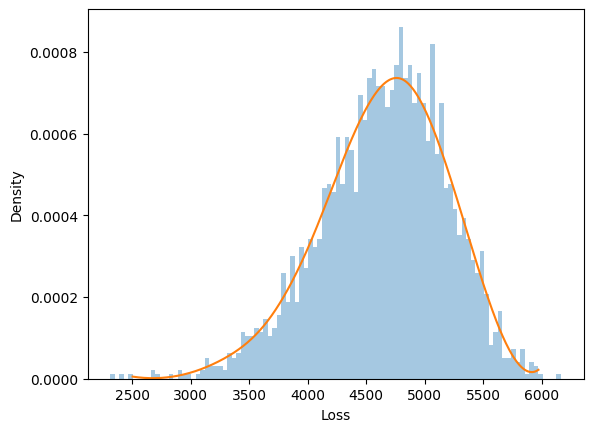

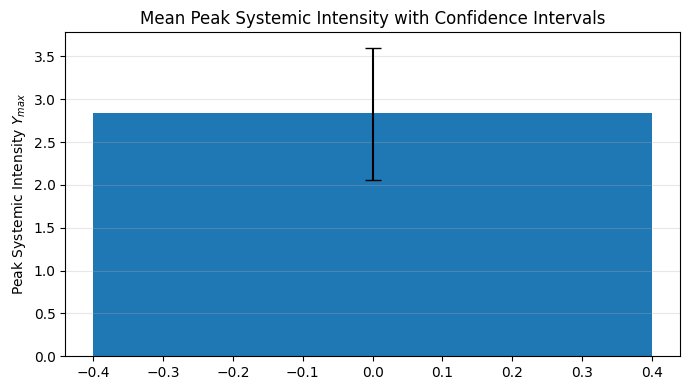

0.9286947285387457


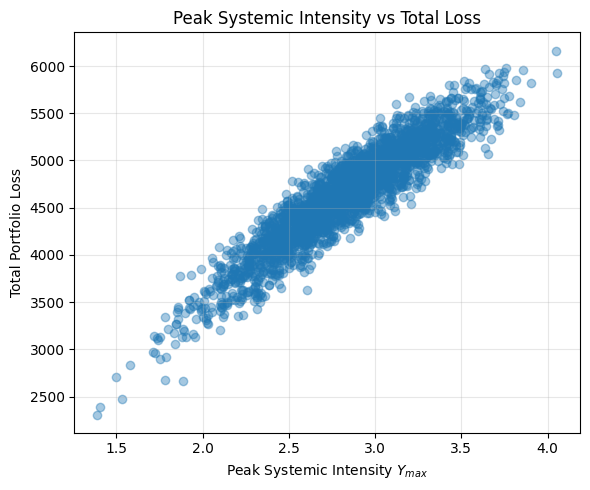

In [28]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f, Y_max_vals_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_loss_metrics(losses_f, alpha=0.95)
int_metrics_f = peak_intensity_metrics(Y_max_vals_f)
metrics_f_df = pd.DataFrame({**metrics_f, **int_metrics_f}, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French Loan')
plot_mean_peak_intensity([Y_max_vals_f], ci=0.95)

print(np.corrcoef(Y_max_vals_f, losses_f)[0,1])
plot_Ymax_vs_loss(Y_max_vals_f, losses_f)

           Mean      Std         VaR          ES  Excess ES  ExcessKurtosis  \
Linear 2.654655 0.390654 5183.208333 5344.736667 161.528334        0.107900   

            Q90      Q95      Q99  
Linear 3.143728 3.287001 3.520692  


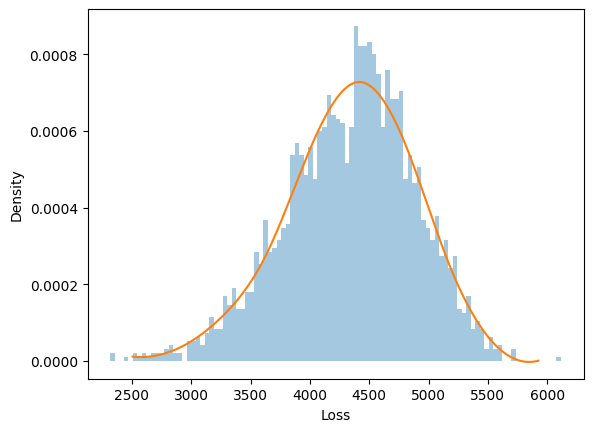

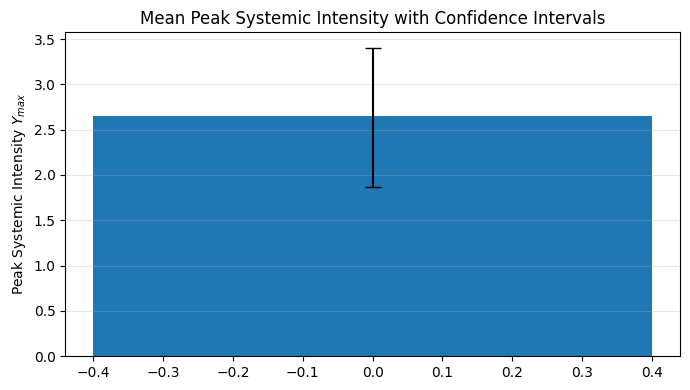

0.9356300098740903


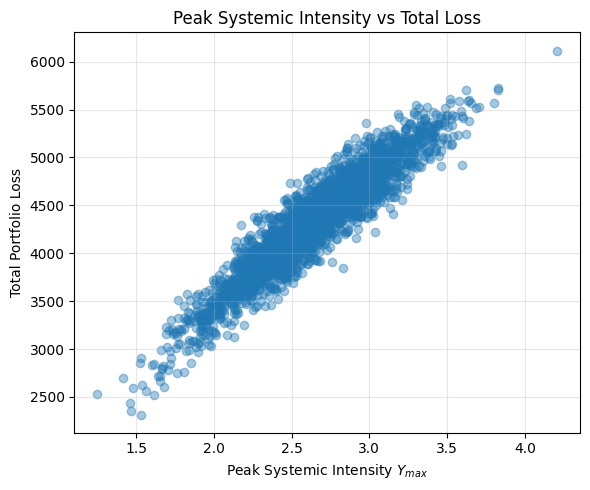

In [29]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l, Y_max_vals_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_loss_metrics(losses_l, alpha=0.95)
int_metrics_l = peak_intensity_metrics(Y_max_vals_l)
metrics_l_df = pd.DataFrame({**metrics_l, **int_metrics_l}, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear Loan')
plot_mean_peak_intensity([Y_max_vals_l], ci=0.95)

print(np.corrcoef(Y_max_vals_l, losses_l)[0,1])
plot_Ymax_vs_loss(Y_max_vals_l, losses_l)